# Predict media from taxa

In [2]:
import pandas as pd
from matplotlib import pyplot as plt
import plotly.express as px
from sklearn.cluster import KMeans
import umap

import os
DATA_DIR = "~/Desktop/code/data/"

In [3]:
TARGET_VAR = "taxon_id"

RANDOM_SEED = 666

# UMAP parameters
UMAP_METRIC = "euclidean"
UMAP_SEED = 42

In [4]:
data_df = pd.read_csv(os.path.join(DATA_DIR, "ec-taxa-media-overlap.csv"), low_memory=False)

filter = data_df["ec"].str.contains("-")
data_df = data_df[~filter]

data_df = data_df[["taxon_id", "media_id", "ec"]]\
    .value_counts()\
    .reset_index()

data_df = data_df.pivot(
    index=["taxon_id", "media_id"],
    columns="ec",
    values="count"
)
data_df = data_df.fillna(0.0).reset_index()
data_df

ec,taxon_id,media_id,1.1.1.1,1.1.1.103,1.1.1.11,1.1.1.119,1.1.1.14,1.1.1.18,1.1.1.2,1.1.1.22,...,3.5.2.10,3.5.2.6,3.5.3.1,3.5.3.3,3.5.5.1,4.1.1.73,4.2.1.32,4.4.1.1,6.2.1.57,6.3.1.20
0,1004166,1a,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1004261,J181,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1004261,J455,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1005925,J118,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1005926,J118,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7215,"[{'NCBI tax id': 999415, 'Matching level': 'st...",J84,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7216,"[{'NCBI tax id': 999428, 'Matching level': 'st...",J144,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7217,"[{'NCBI tax id': 999429, 'Matching level': 'st...",J144,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7218,"[{'NCBI tax id': 999430, 'Matching level': 'st...",J144,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Model

### Strategy for splitting

In [5]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    data_df.drop(["taxon_id", "media_id"], axis=1),
    data_df[TARGET_VAR],
    test_size=0.2,
    random_state=RANDOM_SEED
)

### Dimensionality reduction

In [6]:
reducer = umap.UMAP(
    metric=UMAP_METRIC,
    n_components=8, # 4 components allows us to easily visualize in 3 dimensions, can reduce to 2-3 for figures/PCA/etc; 2 comps has 8 clusters, try 8 comps
    n_epochs=5000,
    random_state=UMAP_SEED,
    n_jobs=1
)

reduced_df = reducer.fit_transform(X_train)
reduced_df = pd.DataFrame(
    reduced_df,
    columns=[f"Component {i+1}" for i in range(reduced_df.shape[1])]
)
reduced_df.head()

,Component 1,Component 2,Component 3,Component 4,Component 5,Component 6,Component 7,Component 8
0,20.363604,-2.949864,16.410204,7.322316,4.646043,5.578499,4.050677,3.708533
1,-3.181324,23.876665,2.782244,9.233506,2.256025,2.981417,19.164820,8.379067
2,25.117611,28.434988,5.323330,3.679507,3.453241,1.217751,6.121018,7.165801
3,15.885609,3.353352,-34.843918,42.104763,6.562959,-16.065195,-15.789804,10.936203
4,15.019388,-2.102371,-25.734983,29.648998,6.576852,-10.344643,-12.844806,10.054972


### Clustering

Elbow and silhouette methods can be used to calculate an optimal number of clusters for our reduced dataset, then clusters can be formed accordingly: https://stackoverflow.com/questions/19197715/scikit-learn-k-means-elbow-criterion

Text(0, 0.5, 'SSE')

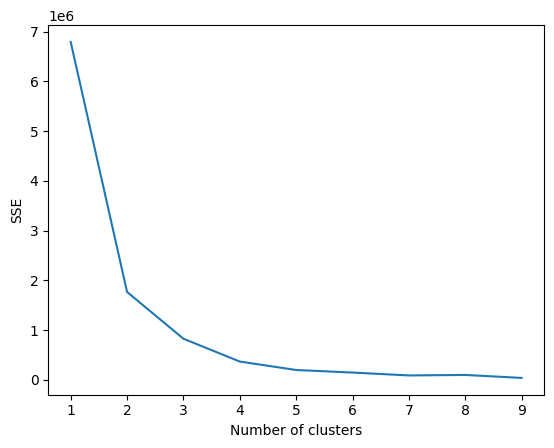

In [7]:
# Elbow criterion method

data = reduced_df.copy()
OMP_NUM_THREADS=2 #prevents data leakage on Windows

sse = {}
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(data)
    data["clusters"] = kmeans.labels_
    #print(data["clusters"])
    sse[k] = kmeans.inertia_ # Inertia: Sum of distances of samples to their closest cluster center
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of clusters")
plt.ylabel("SSE")

In [8]:
# Silhouette coefficient method

from sklearn.metrics import silhouette_score

X = reduced_df.copy()
y = TARGET_VAR

for n_cluster in range(2, 11):
    kmeans = KMeans(n_clusters=n_cluster).fit(X)
    label = kmeans.labels_
    sil_coeff = silhouette_score(X, label, metric='euclidean')
    print("For n_clusters={}, The Silhouette Coefficient is {}".format(n_cluster, sil_coeff))

# Consider: the highest coefficient typically implies the best number of clusters, but if we have 4 components: in the case where 3 clusters = 0.85
    # and 5 clusters = 0.80, the latter is more appropriate since you shouldn't have n clusters > n samples/components

For n_clusters=2, The Silhouette Coefficient is 0.7152437567710876
For n_clusters=3, The Silhouette Coefficient is 0.7537371516227722
For n_clusters=4, The Silhouette Coefficient is 0.8528866767883301
For n_clusters=5, The Silhouette Coefficient is 0.9004213809967041
For n_clusters=6, The Silhouette Coefficient is 0.9189715385437012
For n_clusters=7, The Silhouette Coefficient is 0.8222386837005615
For n_clusters=8, The Silhouette Coefficient is 0.837615430355072
For n_clusters=9, The Silhouette Coefficient is 0.7947757840156555
For n_clusters=10, The Silhouette Coefficient is 0.849150538444519


Use the suggested optimal number of clusters:

In [11]:
cluster = KMeans(
    n_clusters=6, # through different iterations 5 or 6 clusters can be considered more appropriate
    random_state=RANDOM_SEED
)

clust_df = reduced_df.copy()
clust_df["Cluster"] = cluster.fit_predict(clust_df.values)
clust_df["Cluster"] = clust_df["Cluster"].astype(str)

# Add ID columns
clust_df[["taxon_id", "media_id"]] = data_df.loc[X_train.index, ["taxon_id", "media_id"]].values

clust_df.to_csv(os.path.join(DATA_DIR, "taxa-model.csv"), index=False)
clust_df.head()

,Component 1,Component 2,Component 3,Component 4,Component 5,Component 6,Component 7,Component 8,Cluster,taxon_id,media_id
0,20.363604,-2.949864,16.410204,7.322316,4.646043,5.578499,4.050677,3.708533,3,103836,J104
1,-3.181324,23.876665,2.782244,9.233506,2.256025,2.981417,19.164820,8.379067,5,76637,J28
2,25.117611,28.434988,5.323330,3.679507,3.453241,1.217751,6.121018,7.165801,2,589240,J104
3,15.885609,3.353352,-34.843918,42.104763,6.562959,-16.065195,-15.789804,10.936203,4,1036778,1a
4,15.019388,-2.102371,-25.734983,29.648998,6.576852,-10.344643,-12.844806,10.054972,4,"[{'NCBI tax id': 113557, 'Matching level': 'su...",J84


#### Visualize the results

In [13]:
fig = px.scatter_3d(
    data_frame=clust_df,
    x="Component 1",
    y="Component 2",
    z="Component 3",
    color = "Cluster",
    color_discrete_sequence=px.colors.qualitative.Pastel,
    hover_data=[
        "taxon_id",
        "media_id"
    ],
    template="plotly_white"
)
fig.show()

In [ ]:
# UMAP Visualization

#import numpy as np
#import umap.plot

#mapper = umap.UMAP().fit(X_train)
#umap.plot.points(mapper)
#umap.plot.connectivity(mapper, show_points=True)
#umap.plot.diagnostic(mapper, diagnostic_type='pca')

#### Create new column from clusters

In [14]:
y_train = cluster.predict(reducer.transform(X_train))
y_test = cluster.predict(reducer.transform(X_test))

y_train

array([3, 5, 2, ..., 4, 5, 5])

### Classifier

In [15]:
import sklearn
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report


model = RandomForestClassifier(
    n_estimators=100,
    n_jobs=-1,
    random_state=RANDOM_SEED
)
model.fit(X_train, y_train)

RandomForestClassifier(n_jobs=-1, random_state=666)

### Performance

#### Metrics

In [16]:
y_pred = model.predict(X_test)

report = classification_report(
    y_true=y_test,
    y_pred=y_pred,
    zero_division="warn"
)

print(report)

              precision    recall  f1-score   support

           0       0.77      1.00      0.87        17
           1       0.99      0.98      0.99       377
           2       0.99      0.95      0.97       105
           3       0.98      0.95      0.96       330
           4       0.95      0.98      0.97       520
           5       0.93      0.89      0.91        95

    accuracy                           0.97      1444
   macro avg       0.94      0.96      0.95      1444
weighted avg       0.97      0.97      0.97      1444



In [17]:
from sklearn import metrics

# TODO: get PR-REC AUC score
# TODO: plot both ROC and PR-REC curves
roc_score = metrics.roc_auc_score(
    y_true=y_test,
    y_score=model.predict_proba(X_test),
    average="weighted",
    multi_class="ovo"
)

print("ROC AUC score:", roc_score)

ROC AUC score: 0.9794851552408825


#### Feature Importances

In [ ]:
import xgboost
import shap

# train an XGBoost model
model2 = xgboost.XGBRegressor().fit(X_train, y_train)

# explain the model's predictions using SHAP
# (same syntax works for LightGBM, CatBoost, scikit-learn, transformers, Spark, etc.)
explainer = shap.Explainer(model2)
shap_values = explainer(X_train)

shap.plots.initjs()

In [ ]:
# visualize all the training set predictions
#shap.plots.force(shap_values[:1000])

In [ ]:
# summarize the effects of all the features
#shap.plots.beeswarm(shap_values)